In [11]:
#Importo dependencias
import scipy
import pandas as pd
import numpy as np
import math

248 evaluations required.


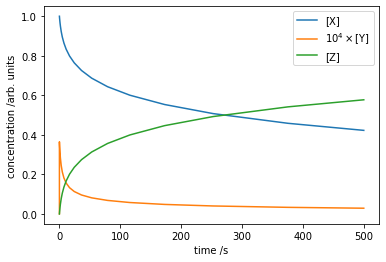

In [12]:
#EJEMPLO:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def deriv(t, y):
    """ODEs for Robertson's chemical reaction system."""
    x, y, z = y
    xdot = -0.04 * x + 1.e4 * y * z
    ydot = 0.04 * x - 1.e4 * y * z - 3.e7 * y**2
    zdot = 3.e7 * y**2
    return xdot, ydot, zdot

# Initial and final times.
t0, tf = 0, 500
# Initial conditions: [X] = 1; [Y] = [Z] = 0.
y0 = 1, 0, 0
# Solve, using a method resilient to stiff ODEs.
soln = solve_ivp(deriv, (t0, tf), y0, method='Radau')
print(soln.nfev, 'evaluations required.')

# Plot the concentrations as a function of time. Scale [Y] by 10**YFAC
# so its variation is visible on the same axis used for [X] and [Z].
YFAC = 4
plt.plot(soln.t, soln.y[0], label='[X]')
plt.plot(soln.t, 10**YFAC*soln.y[1], label=r'$10^{}\times$[Y]'.format(YFAC))
plt.plot(soln.t, soln.y[2], label='[Z]')
plt.xlabel('time /s')
plt.ylabel('concentration /arb. units')
plt.legend()
plt.show()

In [13]:
#Importo parámetros
#Parámetros de la evolución química del sistema
tmax = 100e-6 #1.833973816e-010 // 1e5 //100e-6
R0 = 1e-6
Rmax = 1000e-6
T0 = 300
Tmax = 6000
sigmaT = 1e-6


#Parámetros químicos:
n_species = 8
n_reacc = 28
Na = 6.0221367e23 #defino el nro de avogadro

#Condiciones iniciales
#Orden:
#n[n_species] = {n[0],     n[1],   n[2],   n[3],   n[4],   n[5],   n[6],   n[7]}
#n[n_species] =      {H2,       H,      O,      O2,     OH,     H2O,    H2O2,   HO2}
#n0[n_species] = {0.0,   0.0,   0.5e8,    0.5e8,  0.0}
#n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0])
n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0,    1.0e8,    0.0,    0.0])
#Masas:
#masa de H: 1,00784 u (unidad de masa atómica)
#masa de O: 15,999 u
masa_H = 1.00784
masa_O = 15.999
masa_species = np.array([2*masa_H, masa_H, masa_O, 2*masa_O, masa_H + masa_O, 2*masa_H + masa_O, 2*masa_H + 2*masa_O, masa_H + 2*masa_O])




#Gráfico R(t):
# import matplotlib.pyplot as plt
# import numpy as np
# t_array = np.linspace(0, tmax)
# R_array = R(t_array)
# plt.plot(t_array,R_array)

#Grafico T(t):
# import matplotlib.pyplot as plt
# import numpy as np
# t_array = np.linspace(0, 3*sigmaT)
# T_array = T(t_array)
# plt.plot(t_array,T_array)



In [14]:
#FUNCIONES QCAS

def R(t):
    return ((Rmax-R0)/tmax*t  + R0)

def V(t):
    return 4/3 * math.pi * R(t)**3

def dVdt(t):
    return 0
    #return 4*Pi*pow(R(t),2)*(Rmax-R0)/tmax;

def T(t):
    return (Tmax-T0)*np.exp(-0.5*pow(t/sigmaT,2)) + T0



In [15]:
#FUNCIONES MATH

def masa(n):
    m = 0.0
    for i in range(n_species):
        m = m + n[i]*masa_species[i]
    return m

def imprimir_nro_particulas(n_species,n,t, m0):
    print(t, "\t", n[0], "\t", n[1], "\t", n[2], "\t", n[3], "\t", n[4], "\t", n[5], "\t", n[6], "\t", n[7], "\t", masa(n)/m0)


In [16]:
#Calculo la masa inicial
m0 = masa(n0)

In [17]:
def lista_de_reacciones(t, n, r):
    #Para dado t y n, calcula los términos de dndt debido a las reacciones qcas y los carga en r.

    ntot = 0.0
    for i in range(n_species):
        ntot = ntot + n[i]

    MolCov=5.1e-29; #molecular covolumen [m^3]
    VolExcl=np.exp(ntot/V(t)*MolCov/(1.0-ntot/V(t)*MolCov))/(1.0-ntot/V(t)*MolCov)

    #Parametros de disociacion.
    #Son empleados para calcular los cambios debido a las reacciones. Creo que los que no están presentados son todos 0.
    t1=1.0
    t2=1.0
    t5=1.0
    t6=1.0
    t15=-1.0
    t16=1.0
    t33=-1.0
    t34=-1.0
    t39=1.0

    #Cargo las reacciones: par es forward, impar es backwards.

    #Reacción 1: O + O + M -> O2 + M
    r[0]=pow(VolExcl,t1)*1.2e17*(1.0e-12)*(ntot/V(t))*(n[2]/V(t))*(n[2]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[1]=3.16e19*(1.0e-6)*(ntot/V(t))*(n[3]/V(t))*pow(T(t),-1.3)*np.exp(-59893.0/T(t))/Na

    #Reacción 2: O + H + M -> OH + M
    r[2]=pow(VolExcl,t2)*5.0e17*(1.0e-12)*(ntot/V(t))*(n[2]/V(t))*(n[1]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[3]=3.54e17*(1.0e-6)*(ntot/V(t))*(n[4]/V(t))*pow(T(t),-0.9)*np.exp(-51217.0/T(t))/Na

    #Reacción 3: O + H2 -> H + OH
    r[4]=3.87e4*(1.0e-6)*(n[2]/V(t))*(n[0]/V(t))*pow(T(t),2.7)*np.exp(-3150.0/T(t))/Na
    r[5]=1.79e4*(1.0e-6)*(n[1]/V(t))*(n[4]/V(t))*pow(T(t),2.7)*np.exp(-2200.0/T(t))/Na

    #Reacción 4: H + O2 -> O +OH
    r[6]=2.65e16*(1.0e-6)*(n[1]/V(t))*(n[3]/V(t))*pow(T(t),-0.7)*np.exp(-8576.0/T(t))/Na
    r[7]=9.0e13*(1.0e-6)*(n[2]/V(t))*(n[4]/V(t))*pow(T(t),-0.3)*np.exp(83.0/T(t))/Na

    #Reacción 5: H + H + M -> H2 + M
    r[8]=pow(VolExcl,t5)*1.0e18*(1.0e-12)*(ntot/V(t))*(n[1]/V(t))*(n[1]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[9]=7.46e17*(1.0e-6)*(ntot/V(t))*(n[0]/V(t))*pow(T(t),-0.8)*np.exp(-52177.0/T(t))/Na

    #Reacción 6: H + OH + M -> H2O + M
    r[10]=pow(VolExcl,t6)*2.2e22*(1.0e-12)*(ntot/V(t))*(n[1]/V(t))*(n[4]/V(t))*pow(T(t),-2.0)*np.exp(-0.0/T(t))/Na/Na
    r[11]=3.67e23*(1.0e-6)*(ntot/V(t))*(n[5]/V(t))*pow(T(t),-2.0)*np.exp(-59980.0/T(t))/Na

    #Reacción 7: OH + H2 -> H + H2O
    r[12]=2.16e8*(1.0e-6)*(n[4]/V(t))*(n[0]/V(t))*pow(T(t),1.5)*np.exp(-1726.0/T(t))/Na
    r[13]=5.2e9*(1.0e-6)*(n[1]/V(t))*(n[5]/V(t))*pow(T(t),1.3)*np.exp(-9529.0/T(t))/Na

    #Reacción 8: OH + OH -> O + H2O
    r[14]=3.57e4*(1.0e-6)*(n[4]/V(t))*(n[4]/V(t))*pow(T(t),2.4)*np.exp(-1062.0/T(t))/Na
    r[15]=1.74e6*(1.0e-6)*(n[2]/V(t))*(n[5]/V(t))*pow(T(t),2.2)*np.exp(-7693.0/T(t))/Na

    #Reacción 46: antes numeradas 90 y 91: HO2 + HO2 -> H2O2 + O2
    r[16]=3.0e12*(1.0e-6)*(n[7]/V(t))*(n[7]/V(t))*pow(T(t),0.0)*np.exp(-700.0/T(t))/Na
    r[17]=4.53e14*(1.0e-6)*(n[6]/V(t))*(n[3]/V(t))*pow(T(t),-0.39)*np.exp(-19700.0/T(t))/Na

    #Reacción 47: antes numeradas 92 y 93: H2O2 -> OH + OH
    r[18]=1.2e17*(1.0e-6)*(n[6]/V(t))*(ntot/V(t))*pow(T(t),0.0)*np.exp(-22900.0/T(t))/Na
    r[19]=9.0e5*(1.0e-12)*(ntot/V(t))*(n[4]/V(t))*(n[4]/V(t))*pow(T(t),0.9)*np.exp(3050.0/T(t))/Na/Na

    #Reacción 48: antes numeradas 94 y 95: H2O2 + H -> H2O + OH
    r[20]=3.2e14*(1.0e-6)*(n[6]/V(t))*(n[1]/V(t))*pow(T(t),0.0)*np.exp(-4510.0/T(t))/Na
    r[21]=1.14e9*(1.0e-6)*(n[5]/V(t))*(n[4]/V(t))*pow(T(t),1.36)*np.exp(-38180.0/T(t))/Na

    #Reacción 49: antes numeradas 96 y 97: H2O2 + H -> H2 + HO2
    r[22]=4.82e13*(1.0e-6)*(n[6]/V(t))*(n[1]/V(t))*pow(T(t),0.0)*np.exp(-4000.0/T(t))/Na
    r[23]=1.41e11*(1.0e-6)*(n[0]/V(t))*(n[7]/V(t))*pow(T(t),0.66)*np.exp(-12320.0/T(t))/Na

    #Reacción 50: antes numeradas 98 y 99: H2O2 + O -> OH + HO2
    r[24]=9.55e6*(1.0e-6)*(n[6]/V(t))*(n[2]/V(t))*pow(T(t),2.0)*np.exp(-2000.0/T(t))/Na
    r[25]=4.62e3*(1.0e-6)*(n[4]/V(t))*(n[7]/V(t))*pow(T(t),2.75)*np.exp(-9277.0/T(t))/Na

    #Reacción 51: antes numeradas 100 y 101: H2O2 + OH -> H2O + HO2
    r[26]=1.00e13*(1.0e-6)*(n[6]/V(t))*(n[4]/V(t))*pow(T(t),0.0)*np.exp(-900.0/T(t))/Na
    r[27]=2.8e13*(1.0e-6)*(n[5]/V(t))*(n[7]/V(t))*pow(T(t),0.0)*np.exp(-16500.0/T(t))/Na

def reacciones_qcas(t, n, dndt):
    #Considera el efecto de todas las reacciones qcas sobre la derivada dndt
    r = np.zeros(n_reacc)
    lista_de_reacciones(t, n, r)

    # //1 reacción:
    # dndt[0]=0
    # dndt[1]=0
    # dndt[2]=V(t)*(-2.0*(r[0]-r[1]))
    # dndt[3]=V(t)*(1.0*(r[0]-r[1]))
    # dndt[4]=0

    # //3 reacciones:
    # dndt[0]=V(t)*(-1.0*(r[4]-r[5]))
    # dndt[1]=V(t)*(-1.0*(r[2]-r[3])+1.0*(r[4]-r[5]))
    # dndt[2]=V(t)*(-2.0*(r[0]-r[1])-1.0*(r[2]-r[3])-1.0*(r[4]-r[5]))
    # dndt[3]=V(t)*(1.0*(r[0]-r[1]))
    # dndt[4]=V(t)*(+1.0*(r[2]-r[3])+1.0*(r[4]-r[5]))

    # //Todas las reacciones que no involucran N (Nitrógeno):
    # //n[0] = y[Nvar2+1] =H2.
    # //n[1] = y[Nvar2+2] =H
    # //n[2] = y[Nvar2+3] =O
    # //n[3] = y[Nvar2+4] =O2
    # //n[4] = y[Nvar2+5] =OH
    # //n[5] = y[Nvar2+6] =H2O = y[4] = vapor
    # //n[6] = y[Nvar2+18] =H2O2. Este es mi n[6]
    # //n[7] = y[Nvar2+19] =HO2

    dndt[0] = dndt[0] + V(t)*(-1.0*(r[4]-r[5])+1.0*(r[8]-r[9])-1.0*(r[12]-r[13])+1.0*(r[22]-r[23]))
    dndt[1] = dndt[1] + V(t)*(-1.0*(r[2]-r[3])+1.0*(r[4]-r[5])-1.0*(r[6]-r[7])-2.0*(r[8]-r[9])-1.0*(r[10]-r[11])+1.0*(r[12]-r[13])-1.0*(r[20]-r[21])-1.0*(r[22]-r[23]))
    dndt[2] = dndt[2] + V(t)*(-2.0*(r[0]-r[1])-1.0*(r[2]-r[3])-1.0*(r[4]-r[5])+1.0*(r[6]-r[7])+1.0*(r[14]-r[15])-1.0*(r[24]-r[24]))
    dndt[3] = dndt[3] + V(t)*(1.0*(r[0]-r[1])-1.0*(r[6]-r[7])+1.0*(r[16]-r[17]))
    dndt[4] = dndt[4] + V(t)*(+1.0*(r[2]-r[3])+1.0*(r[4]-r[5])+1.0*(r[6]-r[7])-1.0*(r[10]-r[11])-1.0*(r[12]-r[13])-2.0*(r[14]-r[15])+2.0*(r[18]-r[19])+1.0*(r[20]-r[21])+1.0*(r[24]-r[24]))
    dndt[5] = dndt[5] + V(t)*(+1.0*(r[10]-r[11])+1.0*(r[12]-r[13])+1.0*(r[14]-r[15])+ 1.0*(r[20]-r[21])+1.0*(r[26]-r[27]))
    dndt[6] = dndt[6] + V(t)*(-1.0*(r[18]-r[19])-1.0*(r[20]-r[21])-1.0*(r[22]-r[23])-1.0*(r[24]-r[24])-1.0*(r[26]-r[27])+1.0*(r[16]-r[17]))
    dndt[7] = dndt[7] + V(t)*(-2.0*(r[16]-r[17])+1.0*(r[22]-r[23])+1.0*(r[24]-r[24])+1.0*(r[26]-r[27]))

    return


In [ ]:
def condensacion():
    


    return

In [ ]:

def derivada(t, n):
    #Calculo la derivada dndt
    dndt = np.zeros(n_species)

    #Considero que ocuren reacciones qcas
    reacciones_qcas(t,n,dndt)

    imprimir_nro_particulas(n_species,n,t, m0)

    
    return dndt

In [18]:


#Creo el vector de nro de partículas y lo inicializo
n = np.zeros(n_species)
for i in range(n_species):
    n[i] = n0[i]


t0=0.0; #Inicializacion del tiempo
    
#Creo el vector de dndt y lo inicializo
dndt = np.zeros(n_species)
dndt = derivada(t0, n)



    # //Creo el file en el que voy a ir guardando todo
    # ofstream file(archivo);
    # file << encabezado << endl;

imprimir_nro_particulas(n_species, n, t0, m0) #imprimo la cantidad inicial de partículas de cada especie
#step es el htry, es decir, el salto que (intenta hacer?) el rkqc.

#-------------------------------------------------------------------------------------------------------------------------
#SOLUCIÓN NUMÉRICA EMPLEANDO EL MÉTODO Radau
soln = solve_ivp(derivada, [t0, tmax], n0, method='Radau')


0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
1.7300105521701416e-21 	 99999999.99999756 	 1.4428216613921608e-05 	 7.36633287126567e-07 	 99999999.99999963 	 9.554262752094149e-06 	 99999999.99999045 	 0.0 	 0.0 	 1.0
0.0 	 99999998.50988388 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999994227
0.0 	 100000000.0 	 1.4901161193847656e-14 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 99999998.50988388 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999908356259
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 99999998.50988388 	 0.0

In [19]:
print(soln) #para obtener info. sobre cómo fue la integración numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 694
     njev: 31
      nlu: 152
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.73001055e-19, 1.90301161e-18, 1.92031171e-17,
       1.92204172e-16, 1.92221472e-15, 1.92223202e-14, 1.92223375e-13,
       7.73939073e-13, 1.80560371e-12, 3.44378187e-12, 5.89753784e-12,
       9.55096999e-12, 1.52281938e-11, 2.50954313e-11, 4.70200206e-11,
       1.03247136e-10, 1.74220956e-10, 2.99662046e-10, 5.06540441e-10,
       8.57587378e-10, 1.38011106e-09, 2.20046642e-09, 3.17397783e-09,
       4.14748924e-09, 5.35618975e-09, 6.95543954e-09, 9.27815905e-09,
       1.21314877e-08, 1.58158690e-08, 2.07494733e-08, 2.85554058e-08,
       3.81642965e-08, 5.22214878e-08, 6.90479388e-08, 9.73450597e-08,
       1.26995076e-07, 1.67528661e-07, 2.17350733e-07, 2.83381393e-07,
       3.35202381e-07, 3.68150476e-07, 3.88990228e-07, 4.32539959e-07,
       5.21827908e-07, 6.58294508e-07

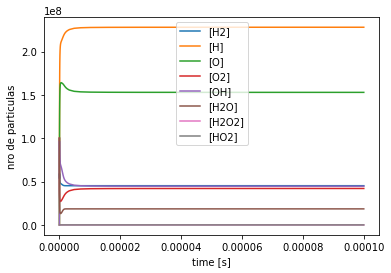

In [20]:
#plt.figure(dpi=1200) #Para mayor resolución
plt.plot(soln.t, soln.y[0], label='[H2]')
plt.plot(soln.t, soln.y[1], label='[H]')
plt.plot(soln.t, soln.y[2], label='[O]')
plt.plot(soln.t, soln.y[3], label='[O2]')
plt.plot(soln.t, soln.y[4], label='[OH]')
plt.plot(soln.t, soln.y[5], label='[H2O]')
plt.plot(soln.t, soln.y[6], label='[H2O2]')
plt.plot(soln.t, soln.y[7], label='[HO2]')
plt.xlabel('time [s]')
plt.ylabel('nro de particulas')
plt.legend()
plt.show()

